<a href="https://colab.research.google.com/github/Ssurf777/GAN_sample/blob/main/Wasserstein_GAN_Gradient_Penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 共通部分の作成

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=100)
parser.add_argument("--batch_size", type = int, default=64)
parser.add_argument("--lr", type = float, default=2e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)
parser.add_argument("--c_lower", type = float, default=-0.01)
parser.add_argument("--c_upper", type = float, default=0.01)
parser.add_argument("--n_critic", type = int, default=5)
parser.add_argument("--gp_weight", type=float, default=10.0)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=100, batch_size=64, lr=0.0002, nch_g=128, nch_d=128, z_dim=100, beta1=0.5, c_lower=-0.01, c_upper=0.01, n_critic=5, gp_weight=10.0)


# Dataインポート・準備

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        super().__init__()
        self.file_list= file_list
        self.transform = transform

    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return Img

    def __len__(self):
        return len(self.file_list)

In [5]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [6]:
import torchvision.datasets as dset

In [ ]:
dataset = dset.MNIST("./ ", train=True,download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16382347.50it/s]


Extracting ./ /MNIST/raw/train-images-idx3-ubyte.gz to ./ /MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 492203.43it/s]


Extracting ./ /MNIST/raw/train-labels-idx1-ubyte.gz to ./ /MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4519419.50it/s]


Extracting ./ /MNIST/raw/t10k-images-idx3-ubyte.gz to ./ /MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3873633.34it/s]

Extracting ./ /MNIST/raw/t10k-labels-idx1-ubyte.gz to ./ /MNIST/raw



In [7]:
dataset = dset.MNIST("./drive/MyDrive/", download=False, train=True, transform=transform)

In [8]:
from torch.utils.data import DataLoader
import torch.nn as nn

In [9]:
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

# 重み初期化

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# DCGANの実装

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils

# Generator作成
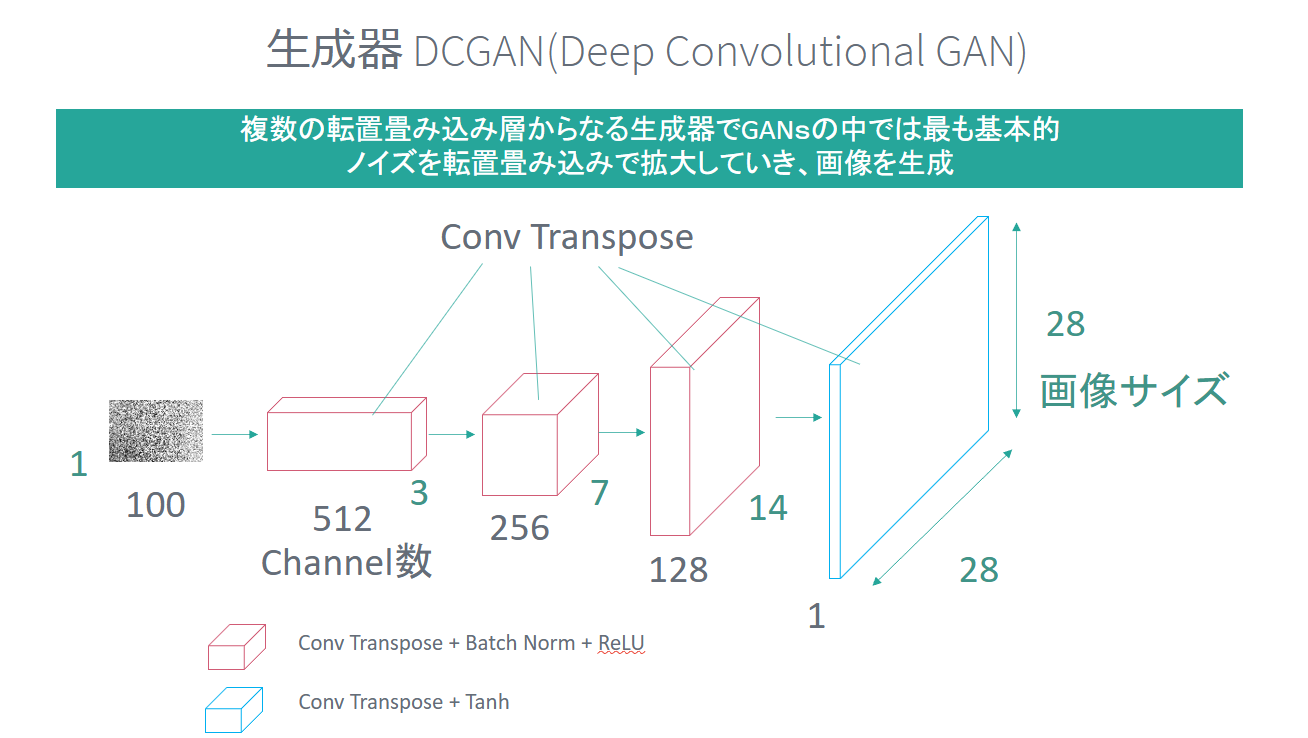

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128, nc=1):
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4 * ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4 * ngf, 2 * ngf,3, 2, 0)
        self.convt3 = self.conv_trans_layers(2 * ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(nn.ConvTranspose2d(ngf, nc, 4, 2, 1), nn.Tanh())
    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
              nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                  stride, padding, bias=False),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out

### Generator size check

In [ ]:
x = torch.randn([32,100,1,1])
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g)
out = netG(x)

In [ ]:
out.size()

torch.Size([32, 1, 28, 28])

# Disctiminatorの作成
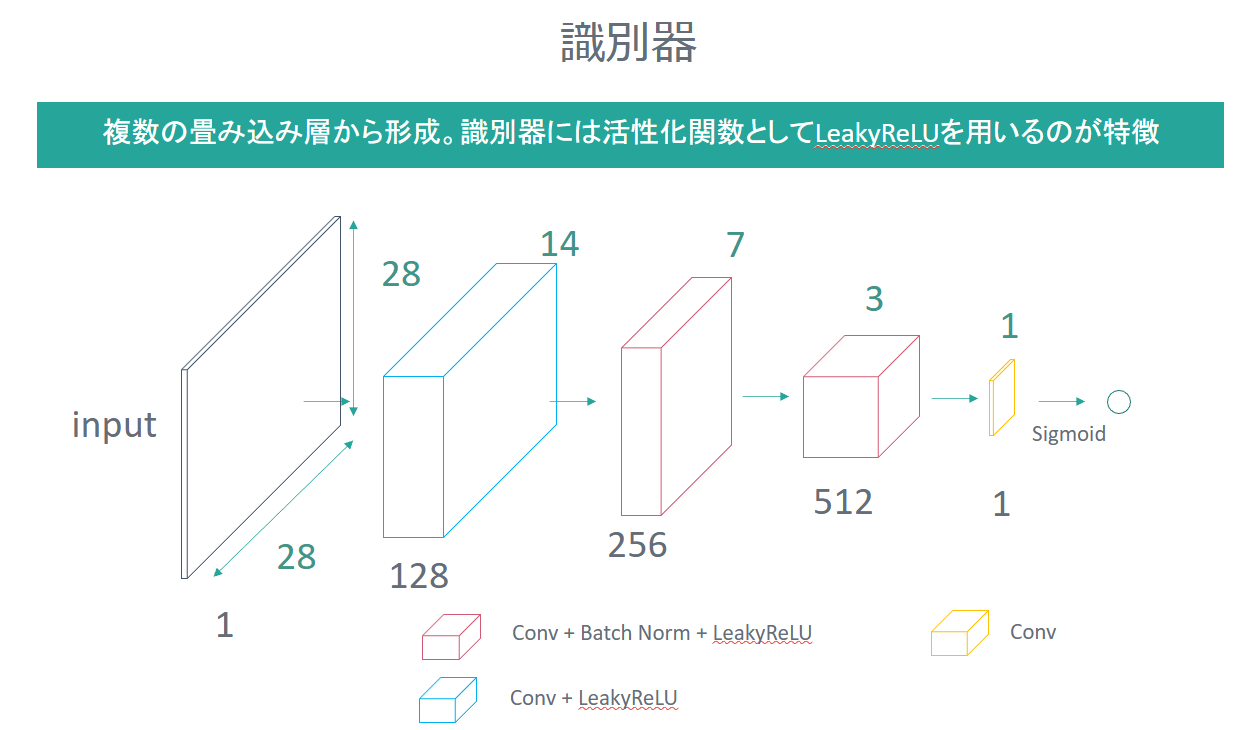

GP版はbatch_normはFalseとなる

In [14]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm=False)
        self.conv2 = self.conv_layers(ndf, 2 * ndf, has_batch_norm=False)
        self.conv3 = self.conv_layers(2 * ndf,4 * ndf, 3, 2, 0, has_batch_norm=False)
        self.conv4 = nn.Sequential( nn.Conv2d(4*ndf, 1, 3, 1, 0), nn.Sigmoid() )
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                    has_batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                      padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        net = nn.Sequential(*layers)
        return net
    def forward(self, x):
        out= self.conv1(x)
        out= self.conv2(out)
        out= self.conv3(out)
        out= self.conv4(out)
        return out

### Discriminator size check

In [ ]:
x = torch.randn(32, 1, 28, 28)
netD = Discriminator(nc=1, ndf=opt.nch_d)
out = netD(x)

In [ ]:
out.size()

torch.Size([32, 1, 1, 1])

# Training

In [15]:
import os

In [16]:
dir_path = "./drive/MyDrive/result"
os.makedirs(dir_path, exist_ok=True)

In [17]:
dataset = dset.MNIST(root="./drive/MyDrive/", download=False, train=True, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
netG = Generator(z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
netG.apply(weights_init)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

In [38]:
netD = Discriminator(nc=1, ndf=opt.nch_d).to(device)
netD.apply(weights_init)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
  )
)

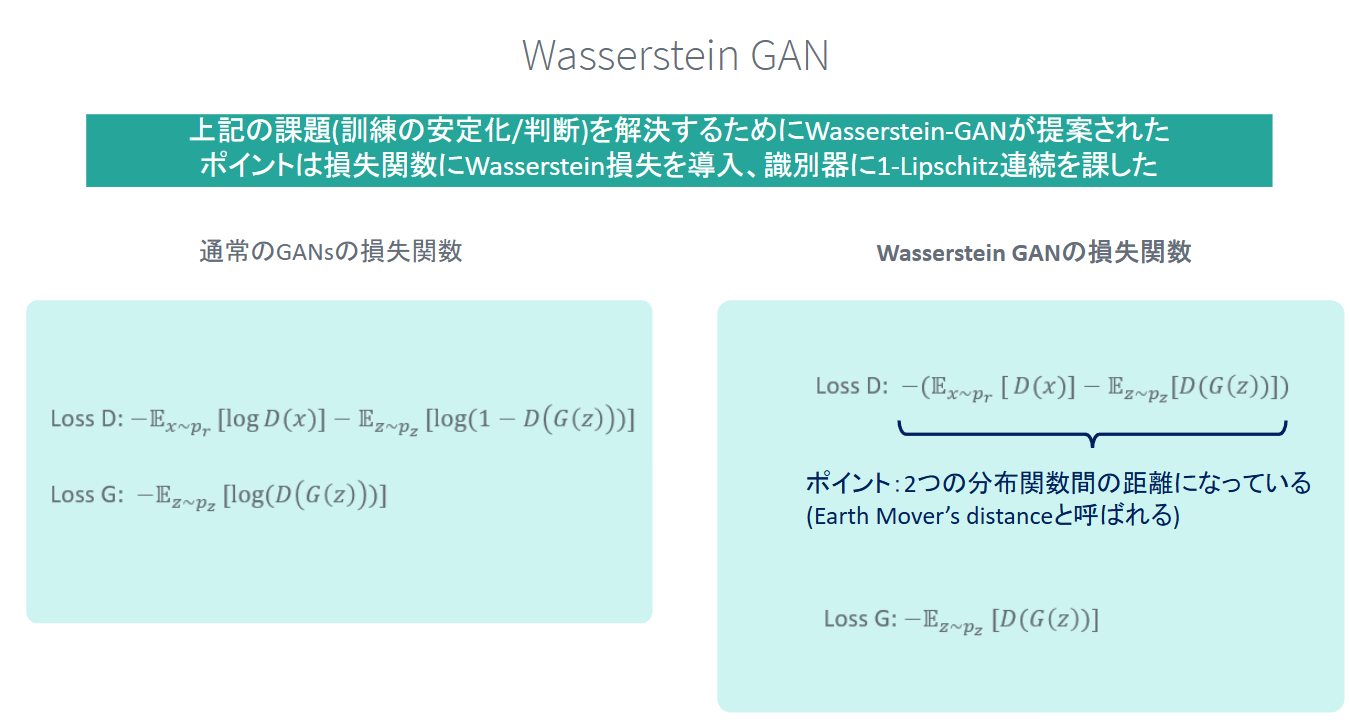

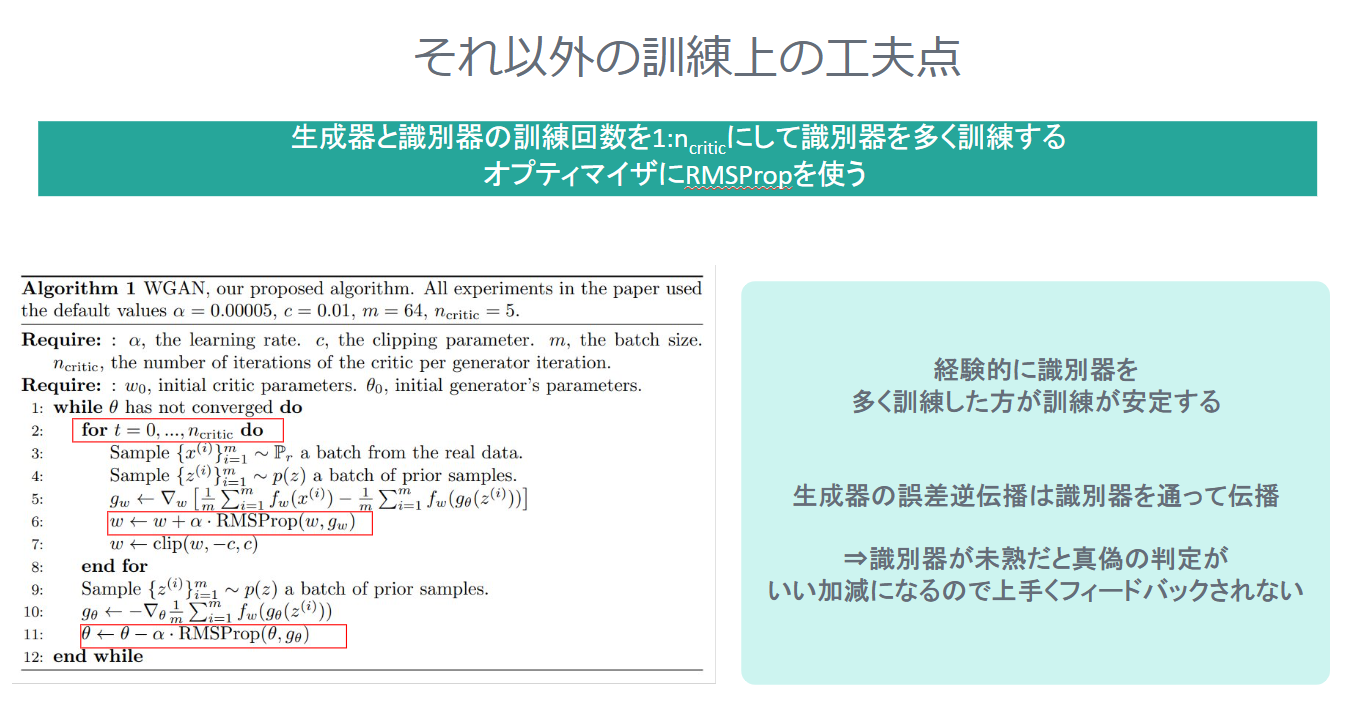

In [39]:
import torch.optim as optim
criterion = nn.BCELoss()

optimizerG = optim.RMSprop(netG.parameters(), lr=opt.lr, weight_decay=1e-4)
optimizerD = optim.RMSprop(netD.parameters(), lr=opt.lr, weight_decay=1e-4)

In [40]:
'''
def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + "/g_{:04d}.pth",format(epoch),
        pickle_module=dill  # Use dill for serialization
    )
    torch.save(
        netD.state_dict(),
        file_path + "/d_{:04d}.pth".format(epoch),
        pickle_module=dill  # Use dill for serialization
    )
'''
def save_params(file_path, epoch, netD, netG):
    filename_g = file_path + "/g_{:04d}.pth".format(epoch) # Format filename outside torch.save
    filename_d = file_path + "/d_{:04d}.pth".format(epoch) # Format filename outside torch.save
    torch.save(
        netG.state_dict(),
        filename_g, # Use the formatted filename
        pickle_module=dill  # Use dill for serialization
    )
    torch.save(
        netD.state_dict(),
        filename_d, # Use the formatted filename
        pickle_module=dill  # Use dill for serialization
    )

In [41]:
model_name = "WGAN-GP"
f_path_result = "./drive/MyDrive/result/{}".format(model_name)
f_path_params = "./drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)


# Gradient penaltyを作成する

alphaの生成: alphaが real_imgs と同じ形状に展開されています。alpha = torch.rand(batch_size, 1, 1, 1) として expand_as を使っているため、正しい形状になります。これにより、real_imgsとfake_imgsの線形補間がバッチごとにランダムになります。

grad_outputs: 勾配の計算に使用される grad_outputs は、interpolated_outと同じサイズで torch.ones で定義されています。これは通常の実装方法で問題ありません。

勾配ノルムの計算と小さな値の加算: gradients_norm の計算で、ゼロ除算を避けるために eps = 1e-12 が追加されています。この対策も正しいです。

retain_graph=True の確認: ここで retain_graph=True は、計算グラフを保持する設定です。メモリを節約するため、もし不要であれば retain_graph=False に設定するのが良いですが、通常のWGAN-GPのトレーニングであれば問題なく使えます。

In [42]:
def gradient_penalty(real_imgs, fake_imgs, gp_weight, netD, device):
    batch_size = real_imgs.size()[0]
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_imgs).to(device)
    interpolated_imgs = (alpha * real_imgs.data + (1 - alpha) * fake_imgs.data).requires_grad_()
    interpolated_out = netD(interpolated_imgs)
    grad_outputs = torch.ones(interpolated_out.size()).to(device)
    gradients = torch.autograd.grad(interpolated_out, interpolated_imgs,
                                    grad_outputs=grad_outputs,
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    eps = 1e-12
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + eps)
    gp = gp_weight * ((gradients_norm - 1)**2).mean()
    return gp

In [43]:
!pip install dill

import dill

### wasserstein GANは損失関数のみ変更

100%|██████████| 938/938 [01:09<00:00, 13.42it/s]


epoch:0, loss:2.413066369797121, lossG:-0.3559038516388201


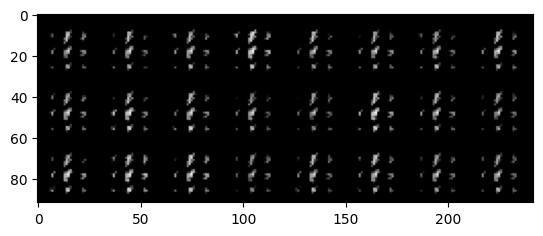

100%|██████████| 938/938 [01:05<00:00, 14.39it/s]


epoch:1, loss:0.6460749542852963, lossG:-0.337131220323127


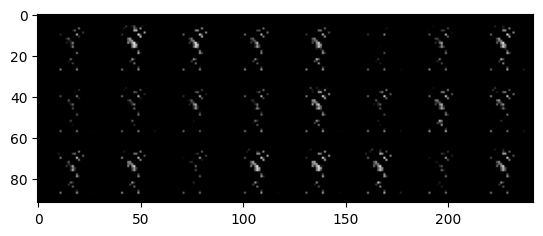

100%|██████████| 938/938 [01:04<00:00, 14.60it/s]


epoch:2, loss:0.3818191665449122, lossG:-0.3226244140154263


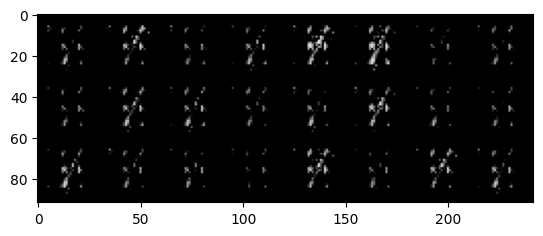

100%|██████████| 938/938 [01:03<00:00, 14.79it/s]


epoch:3, loss:5.5946396423587155, lossG:-0.680056638284914


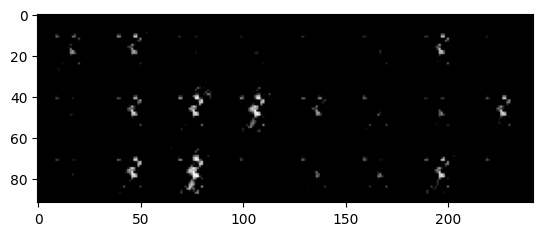

100%|██████████| 938/938 [01:02<00:00, 14.92it/s]


epoch:4, loss:8.68015465651875, lossG:-0.9098532002832271


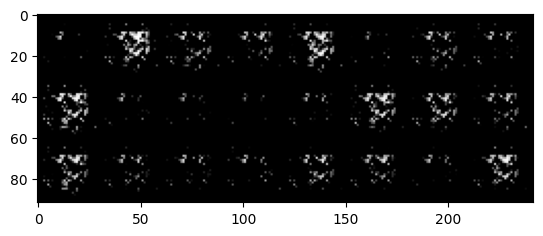

100%|██████████| 938/938 [01:04<00:00, 14.49it/s]


epoch:5, loss:0.23760304955849007, lossG:-0.3050314531461008


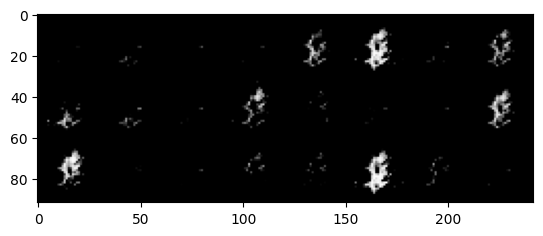

100%|██████████| 938/938 [01:05<00:00, 14.40it/s]


epoch:6, loss:-0.028919551132330253, lossG:-0.28274711783824447


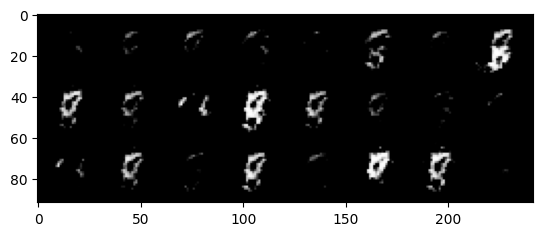

100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


epoch:7, loss:-0.13504379272842204, lossG:-0.27441779028441604


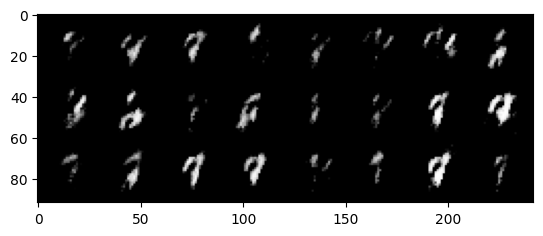

100%|██████████| 938/938 [01:05<00:00, 14.41it/s]


epoch:8, loss:-0.1736527243212088, lossG:-0.290618176160972


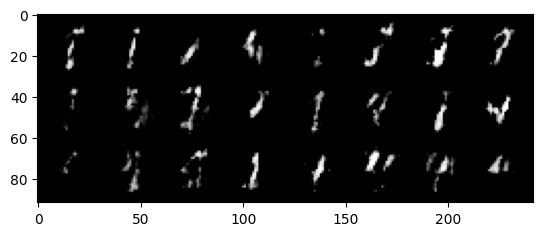

100%|██████████| 938/938 [01:04<00:00, 14.46it/s]


epoch:9, loss:-0.16242583092055848, lossG:-0.3195731087820108


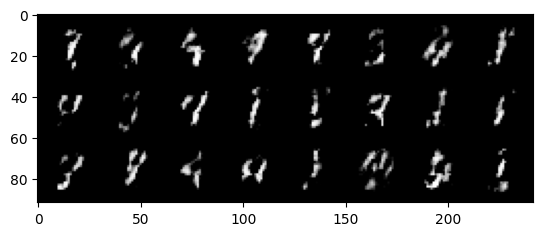

100%|██████████| 938/938 [01:05<00:00, 14.33it/s]


epoch:10, loss:-0.16406912353437847, lossG:-0.33374252678679506


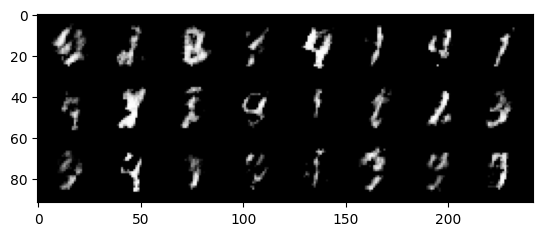

100%|██████████| 938/938 [01:05<00:00, 14.40it/s]


epoch:11, loss:-0.1740745479252928, lossG:-0.35426777872894366


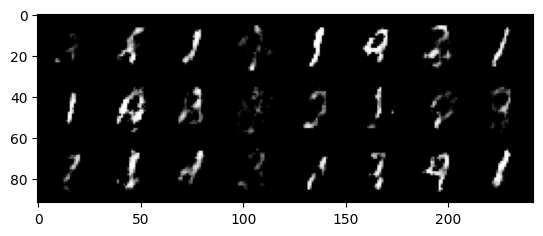

100%|██████████| 938/938 [01:05<00:00, 14.33it/s]


epoch:12, loss:-0.17921783996702256, lossG:-0.3546889343781512


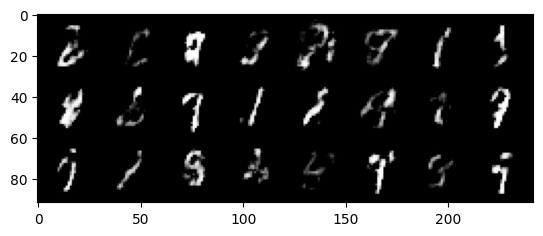

100%|██████████| 938/938 [01:06<00:00, 14.21it/s]


epoch:13, loss:-0.17817443225588372, lossG:-0.3687480391501618


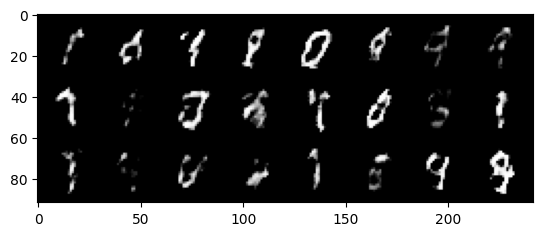

100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


epoch:14, loss:-0.15460245891897154, lossG:-0.3818200703527627


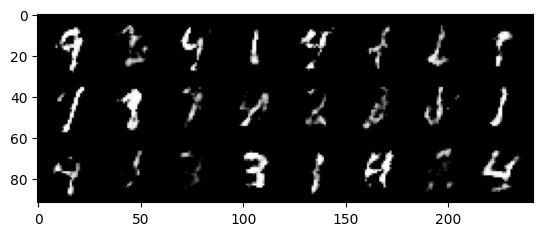

100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


epoch:15, loss:-0.16658243899152222, lossG:-0.385523662415903


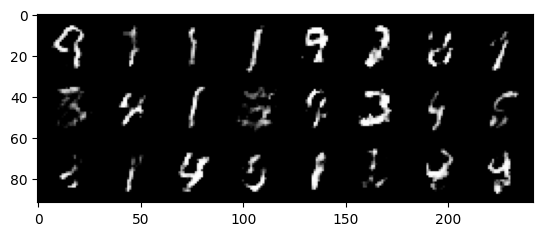

100%|██████████| 938/938 [01:05<00:00, 14.27it/s]


epoch:16, loss:-0.1551879105219709, lossG:-0.39295258943333045


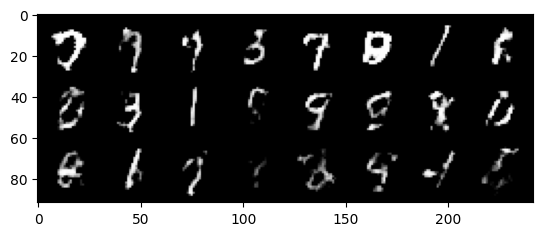

100%|██████████| 938/938 [01:05<00:00, 14.28it/s]


epoch:17, loss:-0.1527517799661358, lossG:-0.40499181629243947


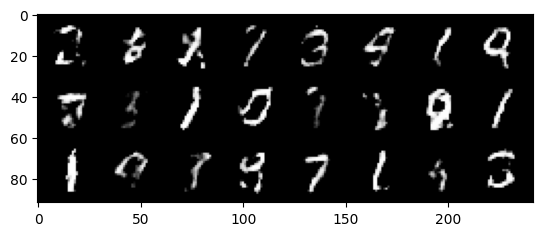

100%|██████████| 938/938 [01:06<00:00, 14.18it/s]


epoch:18, loss:-0.147496277168552, lossG:-0.4069726526228858


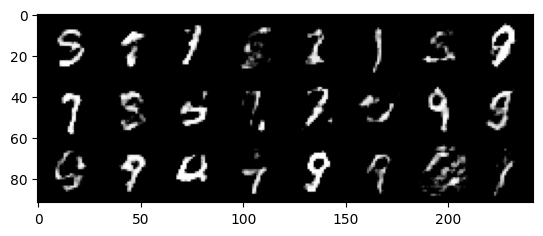

100%|██████████| 938/938 [01:06<00:00, 14.06it/s]


epoch:19, loss:-0.15287949696882194, lossG:-0.4070573733337144


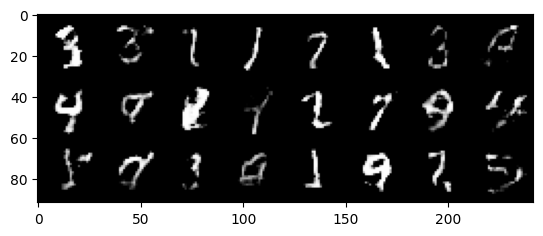

100%|██████████| 938/938 [01:06<00:00, 14.14it/s]


epoch:20, loss:-0.155231383388866, lossG:-0.4150592253597052


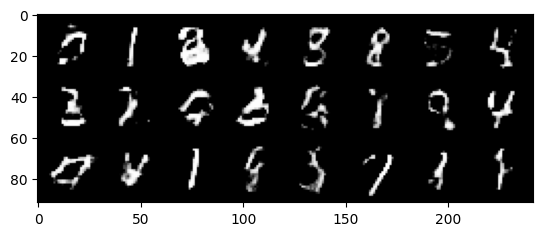

100%|██████████| 938/938 [01:05<00:00, 14.21it/s]


epoch:21, loss:-0.1628545088522724, lossG:-0.4159367508979749


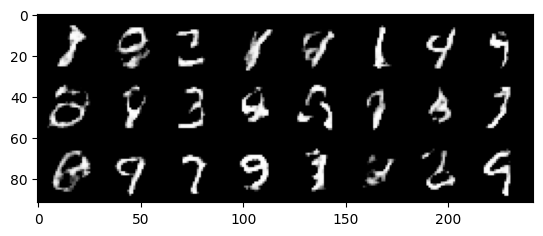

100%|██████████| 938/938 [01:06<00:00, 14.08it/s]


epoch:22, loss:-0.15664146702363294, lossG:-0.4024523562991988


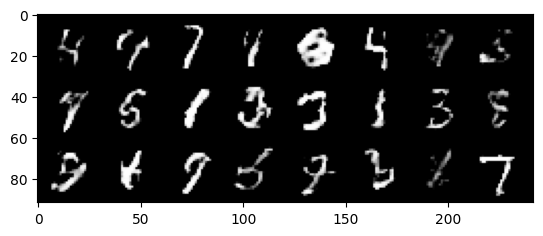

100%|██████████| 938/938 [01:06<00:00, 14.19it/s]


epoch:23, loss:-0.18178199191909356, lossG:-0.4069633284039589


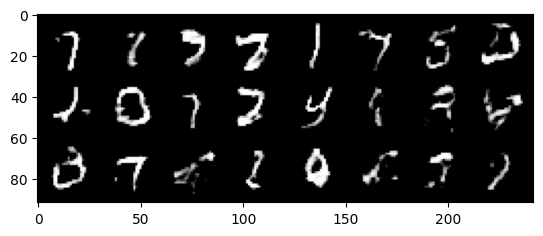

100%|██████████| 938/938 [01:06<00:00, 14.14it/s]


epoch:24, loss:-0.18817272007878402, lossG:-0.39970261600416607


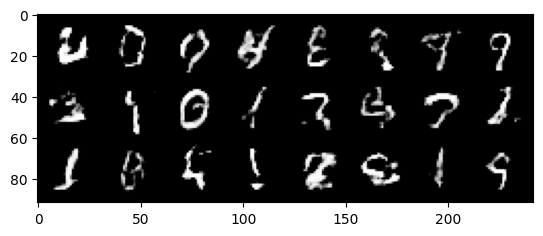

100%|██████████| 938/938 [01:06<00:00, 14.07it/s]


epoch:25, loss:-0.1931760567925505, lossG:-0.3979655885334208


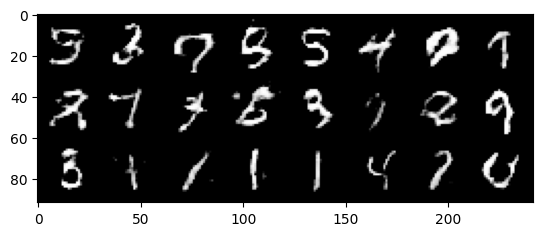

100%|██████████| 938/938 [01:06<00:00, 14.15it/s]


epoch:26, loss:-0.19756017255185765, lossG:-0.3926783976460825


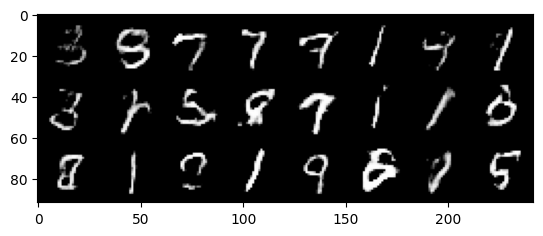

100%|██████████| 938/938 [01:06<00:00, 14.05it/s]


epoch:27, loss:-0.2048923857549805, lossG:-0.39375745632183323


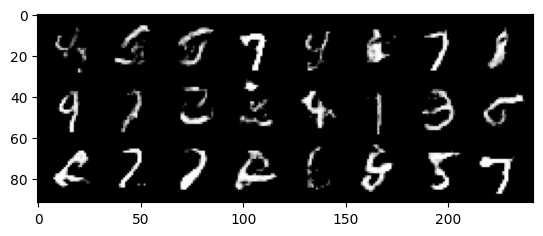

100%|██████████| 938/938 [01:06<00:00, 14.01it/s]


epoch:28, loss:-0.20420940928081713, lossG:-0.3996243910399327


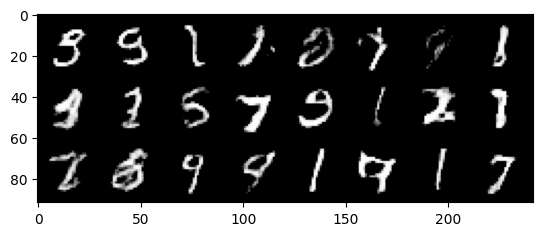

100%|██████████| 938/938 [01:06<00:00, 14.04it/s]


epoch:29, loss:-0.20631591364868415, lossG:-0.4033249174036197


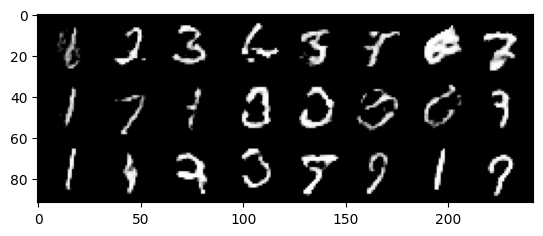

100%|██████████| 938/938 [01:06<00:00, 14.10it/s]


epoch:30, loss:-0.2041374089033492, lossG:-0.4078265301930879


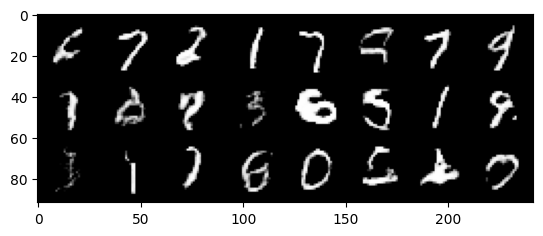

  6%|▌         | 58/938 [00:04<01:03, 13.80it/s]


KeyboardInterrupt: 

In [44]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []

for epoch in range(opt.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position=0)):
        #
        # clip of weight of discriminator
        #
        #for p in netD.parameters():
        #    p.data.clamp_(opt.c_lower, opt.c_upper)

        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)
        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)
        #
        # train Discrimnator
        #
        netD.zero_grad()
        output = netD(real_imgs)
        lossD_real = - torch.mean(output) # wasserstein Distance

        fake_imgs = netG(noise) # Generatorで偽物を生成する
        output = netD(fake_imgs.detach()) # Generotorは更新しないのでdetachする
        lossD_fake = torch.mean(output) # wasserstein Distance
        lossD_gp = gradient_penalty(real_imgs, fake_imgs, opt.gp_weight, netD, device)

        lossD = lossD_real + lossD_fake + lossD_gp
        lossD.backward()
        optimizerD.step() # Discriminatorの更新
        if i % opt.n_critic == 0: # 識別器5回トレーニングしてから生成器を更新

              #
              # train Generator
              #
              netG.zero_grad()
              output = netD(fake_imgs) #
              lossG = -torch.mean(output) # wasserstein Distance
              lossG.backward()
              optimizerG.step()
              raw_lossesG.append(lossG.item())
        #
        # save losses
        #
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print("epoch:{}, loss:{}, lossG:{}".format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)
    #
    # show fake imgs
    #
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()
    #
    # save imgs parameters
    #
    vutils.save_image(fake_imgs, f_path_result + "/{}.jpg".format(epoch))
    save_params(f_path_params, epoch, netD ,netG)

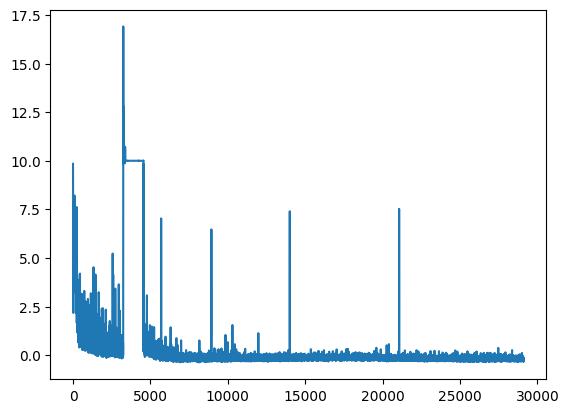

In [45]:
# 識別器の損失関数 plot(raw_lossesD)
plt.plot(raw_lossesD)

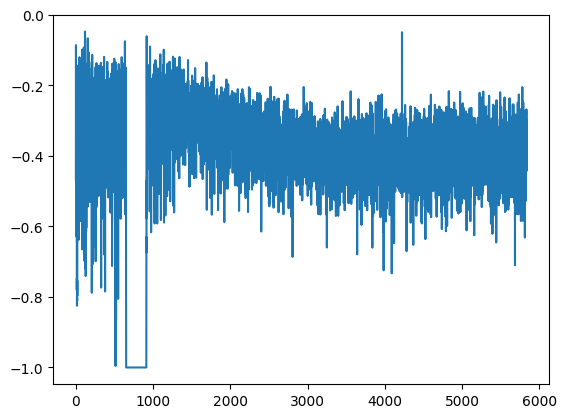

In [46]:
# 生成器の損失関数 plot(raw_lossesG)
plt.plot(raw_lossesG)

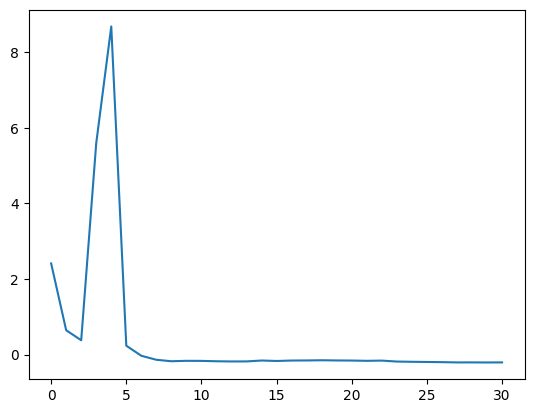

In [47]:
# 識別器の平均損失関数
plt.plot(lossesD)

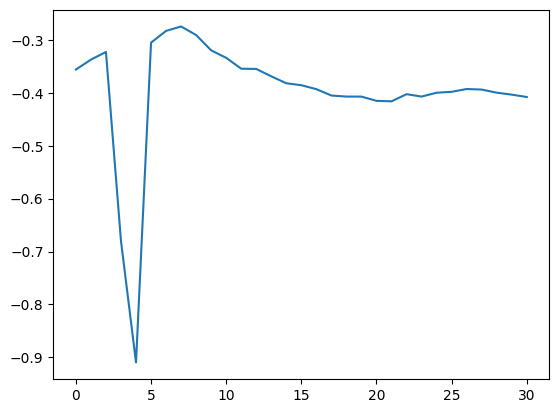

In [48]:
# 生成器の平均損失関数
plt.plot(lossesG)